In [1]:
!pip install -qq git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
# example of using saved cyclegan models for image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import numpy as np

# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,1] to [-1,1]
	X1 = (X1 * 2.0) - 1.0
	X2 = (X2 * 2.0) - 1.0
	return [X1, X2]

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	print(ix)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	images = np.squeeze(images)
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i], cmap='gray')
		# title
		pyplot.title(titles[i])
	pyplot.show()

Loaded (81, 256, 256, 1) (82, 256, 256, 1)
-0.99951171875 0.9999916289628605
[60]
-0.99951171875 0.9999438382973469
-1.0 0.999995


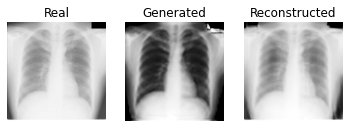

[76]


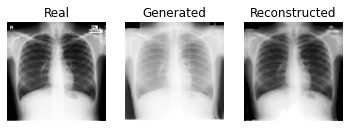

In [3]:
# load dataset
A_data, B_data = load_real_samples('../input/cycleganunet-200epoch-outputs/cyclegan_CXR_train.npz')
print('Loaded', A_data.shape, B_data.shape)
print(A_data.min(), A_data.max())
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('../input/cycleganunet-200epoch-outputs/g_model_AtoB.h5', cust)
model_BtoA = load_model('../input/cycleganunet-200epoch-outputs/g_model_BtoA.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
print(A_real.min(), A_real.max())
B_generated  = model_AtoB.predict(A_real)
print(B_generated.min(), B_generated.max())
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [4]:
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace
from skimage.transform import resize
import cv2

# define location of dataset for Main lung CXR images
folder1 = '../input/cycleganunet-200epoch-outputs/'

#Load all the chest Xrays from respective datasets
jsrt_CXR = np.load(folder1 + 'jsrt_CXR_test.npy')
#convert array from [0,1] to [-1,1] as input for GAN inference
jsrt_CXR = (jsrt_CXR * 2) - 1
print(jsrt_CXR.shape, jsrt_CXR.min(), jsrt_CXR.max())

jsrt_GAN_CXR=[]
for i in range(0,(jsrt_CXR.shape[0])):
    A_real = jsrt_CXR[[i]]
    B_generated  = model_AtoB.predict(A_real)
    jsrt_GAN_CXR.append(B_generated[0])

from numpy import asarray    
jsrt_GAN_CXR=asarray(jsrt_GAN_CXR)
# convert from [-1,1] to [0,1] for UNET inference
jsrt_GAN_CXR=(jsrt_GAN_CXR+1)/2
print(jsrt_GAN_CXR.shape, jsrt_GAN_CXR.min(), jsrt_GAN_CXR.max())

(165, 256, 256, 1) -0.99951171875 1.0000000000000009
(165, 256, 256, 1) 0.0 1.0


In [5]:
print(jsrt_GAN_CXR.shape)
save('jsrt_GAN_CXR.npy', jsrt_GAN_CXR)

from sklearn.model_selection import train_test_split

jsrt_CXR_Mask = np.load('../input/jsrt-data/CXR_Mask.npy')
# Split into train and test data(67%)
X=np.arange(0,246)
X_train, X_test = train_test_split(X, test_size=0.67, random_state=999)
jsrt_CXR_GAN_Mask = jsrt_CXR_Mask[X_test]
print(jsrt_CXR_GAN_Mask.shape)

(165, 256, 256, 1)
(165, 256, 256, 1)


In [6]:
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace 
from skimage.transform import resize
import cv2

#=============================
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from tensorflow.keras.applications import EfficientNetB7
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras import optimizers
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

#===============================================

#jsrt_CXR = np.load('../input/jsrt-data/CXR.npy')
#jsrt_CXR_Mask = np.load('../input/jsrt-data/CXR_Mask.npy')
CXR_test, CXR_Mask_test = jsrt_GAN_CXR, jsrt_CXR_GAN_Mask

In [7]:
#========================================BUILD UNET MODEL=============================================
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D

#========================================BUILD UNET MODEL=============================================
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

#=======Defining UEfficientNet Model
def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.0):
    
    backbone = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[548].output
    print(conv4.shape)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[263].output
    print(conv3.shape)
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[159].output
    print(conv2.shape)
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[55].output
    print(conv1.shape)
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model._name = 'u-xception'

    return model



#====Defining Dice Loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. -score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))




import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau 
from keras import backend as K
import matplotlib.pyplot as plt
import gc

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    #convert to numpy float and then subtract
    #boundary = morphology.dilation(gt, morphology.disk(3)) - gt
    a1 = morphology.dilation(gt, morphology.disk(3))
    a2 = gt
    a1 = a1.astype(np.float32)
    a2 = a2.astype(np.float32)
    boundary = a1 - a2
    
    color_mask[mask == 1] = [1, 0, 0]         #predicted mask - Red color area
    color_mask[boundary == 1] = [0, 0, 1]     # Actual mask - Ground truth - Blue curve
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img
from skimage import morphology, color, io, exposure
import cv2

n_test = CXR_test.shape[0]
dices = np.zeros(n_test)
im_shape = (256, 256)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#del model
K.clear_session()
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model = UEfficientNet(input_shape=input_shape,dropout_rate=0.0)
# Build model
opt = Adam(learning_rate=0.0001)    
model.compile(loss=dice_loss, optimizer=opt, metrics=[dice_coef])
              
i=0
count=0
for xx in range(len(CXR_test)):
    count=count+1
    img = CXR_test[xx]
    # convert gray to BGR. OR 1 channel to 3 channel image
    img = cv2.merge([CXR_test[xx],CXR_test[xx],CXR_test[xx]])
    img = img[np.newaxis,...]

    # Use for single fold predictions
    #model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7.h5')
    #pred = model.predict(img)[..., 0].reshape(input_shape[:2])
    
    # Use for 5 fold predictions
    model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7_0.h5')
    pred0 = model.predict(img)[..., 0].reshape(input_shape[:2])
    model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7_1.h5')
    pred1 = model.predict(img)[..., 0].reshape(input_shape[:2])    
    model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7_2.h5')
    pred2 = model.predict(img)[..., 0].reshape(input_shape[:2]) 
    model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7_3.h5')
    pred3 = model.predict(img)[..., 0].reshape(input_shape[:2])     
    model.load_weights('../input/unet-effnetb7-weights-allfolds/UNET_EFFNETB7_4.h5')
    pred4 = model.predict(img)[..., 0].reshape(input_shape[:2]) 
                  
    pred = (pred0 + pred1 + pred2 + pred3 + pred4)/5.0
    
    img = np.squeeze(CXR_test[xx])
    
    yy = CXR_Mask_test[xx]
    mask = yy[..., 0].reshape(input_shape[:2])
    
    # Binarize masks
    gt = mask > 0.5
    pr = pred > 0.5

    # Remove regions smaller than 2% of the image
    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

    #io.imsave('./'+str(count), masked(img, gt, pr, 1))
    export_path = '../working/'
    image_filename = str(count) + str('.png')
    io.imsave(os.path.join(export_path, image_filename), masked(img, gt, pr, 1)) 

    dices[i] = Dice(gt, pr)
    print(str(count), dices[i])

    i += 1
    if i == n_test:
        break
        
print('Mean Dice:', dices.mean())

258080768/258076736 [==============================] - 3s 0us/step
(None, 16, 16, 1344)
(None, 32, 32, 480)
(None, 64, 64, 288)
(None, 128, 128, 192)
1 0.9693931814153192
2 0.9577706926731683
3 0.9798615986360445
4 0.9682786301547226
5 0.9587199745479612
6 0.9458629710505264
7 0.9725868034840711
8 0.9811625403659849
9 0.9649032258064516
10 0.9641615338764157
11 0.9600868793498062
12 0.971122130234387
13 0.9745360472077311
14 0.972520651291601
15 0.94550309059654
16 0.9439256462900413
17 0.9527858485728935
18 0.9549156143042606
19 0.9588374395072591
20 0.9618346700692673
21 0.9520803557249484
22 0.9680982125489009
23 0.947342187820682
24 0.9768224751755873
25 0.9725035815718702
26 0.9783026913389262
27 0.9640579854538208
28 0.9743125978011259
29 0.976665344964314
30 0.9673754135781887
31 0.955725550810825
32 0.9260673249880694
33 0.974394279778728
34 0.9766152073179516
35 0.9759874479841736
36 0.9585078570826189
37 0.9718539367454263
38 0.964013607354719
39 0.970552023920199
40 0.972907